This notebook demostrates simulating DP1 objects using TDAstro

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import pandas as pd
import sncosmo
from scipy import stats
from scipy.special import expit
from nested_pandas import read_parquet

from tdastro.opsim.opsim import OpSim
from tdastro.astro_utils.passbands import PassbandGroup
from tdastro.astro_utils.pzflow_node import PZFlowNode
from tdastro.astro_utils.snia_utils import (
    DistModFromRedshift,
    HostmassX1Func,
    X0FromDistMod,
    num_snia_per_redshift_bin,
)
from tdastro.math_nodes.scipy_random import SamplePDF
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.simulate import simulate_lightcurves
from tdastro.sources.sncomso_models import SncosmoWrapperModel
from tdastro.sources.snia_host import SNIaHost
from tdastro.utils.plotting import plot_lightcurves
from tdastro.math_nodes.ra_dec_sampler import OpSimUniformRADECSampler
from tdastro.astro_utils.dustmap import DustmapWrapper,SFDMap
from tdastro.effects.extinction import ExtinctionEffect
from tdastro.astro_utils.mag_flux import mag2flux,flux2mag

from tdastro import _TDASTRO_BASE_DATA_DIR

import lsdb
from upath import UPath

We first load the CcdVisit table that we downloaded from Butler, which includes the visit information for simulating the DP1 cadance and noise. Some unit conversions are needed to make sure all the units are consistent within the function that calulates the noise. 

In [2]:
%%time

obs_log = pd.read_csv('dp1_visit_table.txt')
obs_log["numExposures"] = 1
colmap = {"ra":"ra",
          "dec":"dec",
          "time":"expMidptMJD",
          "zp":"zp_nJy", #in Mag
          "filter":"band",
          "skybrightness":"sky_mag_per_arcsecsq", #in ADU
          "seeing": "seeing", #in arcsec
          "exptime": "expTime",
         }
ccdgain = 2.3
pixel_scale = 0.2
#convert zp to nJy
obs_log["zp_nJy"] = mag2flux(obs_log["zeroPoint"])*ccdgain
#convert sky to mag/arcsec^2
obs_log["sky_mag_per_arcsecsq"] = (-2.5*np.log10(obs_log["skyBg"]) + obs_log["zeroPoint"])/pixel_scale**2
opsim_db = OpSim(obs_log,colmap=colmap)
opsim_db.radius = 0.376 #comcam fov = 40arcmin*40arcmin. Currently we can only simulate circular field, so we convert the area to radius (in degree)

t_min, t_max = opsim_db.time_bounds()
print(f"Loaded OpSim with {len(opsim_db)} rows and times [{t_min}, {t_max}]")


Loaded OpSim with 16071 rows and times [60623.25852065384, 60656.35455890054]
CPU times: user 149 ms, sys: 31.7 ms, total: 181 ms
Wall time: 188 ms


We load passband information using `from_preset`, which automatically get the LSST filter information.

In [3]:
passband_group = PassbandGroup.from_preset(preset="LSST")
print(f"Loaded Passbands: {passband_group}")

Loaded Passbands: PassbandGroup containing 6 passbands: LSST_u, LSST_g, LSST_r, LSST_i, LSST_z, LSST_y


Let's calculate the survey length given min and max MJD in the table. This can be used to calculate rate later.

In [4]:
print(f"survey length: {(t_max-t_min)/365} year")

survey length: 0.09067407738820456 year


We utilize the `OpSimUniformRADECSampler` to sample ra and dec uniformly from the area covered by the visit table. Then we define redshift range, cosmology, and use them to compute redshift distribution according to some rate function.

These functions and values are used to define a host galaxy model using pre-defined `SNIaHost` class.

In [5]:
radec_node = OpSimUniformRADECSampler(opsim_db, radius=0.376, node_label="radec")

zmin = 0.001
zmax = 1
H0 = 70.0
Omega_m = 0.3
nsn, z = num_snia_per_redshift_bin(zmin, zmax, 100, H0=H0, Omega_m=Omega_m)
zpdf = interp1d(z, nsn, bounds_error=False, fill_value=0)

host = SNIaHost(
    ra = radec_node.ra,
    dec = radec_node.dec,
    hostmass=10.,
    redshift=SamplePDF(zpdf),
    node_label="host",
)

Now we can define the SED model that is used for generating simulated light curves. The `salt2-h17` model from the `sncosmo` package is used, with necessary parameter distributions defined as FunctionNodes.

In [6]:
distmod_func = DistModFromRedshift(host.redshift, H0=73.0, Omega_m=0.3)
x1_func = NumpyRandomFunc("normal", loc=0, scale=0.2)
c_func = NumpyRandomFunc("normal", loc=0, scale=0.02)
m_abs_func = NumpyRandomFunc("normal", loc=-19., scale=0.1)
x0_func = X0FromDistMod(
    distmod=distmod_func,
    x1=x1_func,
    c=c_func,
    alpha=0.14,
    beta=3.1,
    m_abs=m_abs_func,
    node_label="x0_func",
)

sncosmo_modelname = "salt2-h17"
source = SncosmoWrapperModel(
    sncosmo_modelname,
    t0=NumpyRandomFunc("uniform", low=t_min, high=t_max),
    x0=x0_func,
    x1=x1_func,
    c=c_func,
    ra=NumpyRandomFunc("normal", loc=host.ra, scale=0.01),
    dec=NumpyRandomFunc("normal", loc=host.dec, scale=0.01),
    redshift=host.redshift,
    node_label="source",
)

We can apply milky way extinction effect using `.add_effect`

In [7]:
mwextinction = SFDMap(
    ra=source.ra,
    dec=source.dec,
    node_label="mwext",
)

# Create an extinction effect using the EBVs from that dust map.
ext_effect = ExtinctionEffect(extinction_model="F99", ebv=mwextinction, Rv=3.1)
source.add_effect(ext_effect)

The total area of DP1 is 15 square degrees. We convert it to solid angle and multiply by the survey length to calculate the total number of SN Ia based on the rate function.
Finally we simulate lightcurves using `simulate_lightcurves` providing everything defined above.

In [8]:
%%time
nsntotal, _ = num_snia_per_redshift_bin(zmin, zmax, 1, H0=H0, Omega_m=Omega_m, solid_angle=4.57e-3*0.09) #15 sq degree
print("Total number of SN Ia to be simulated :", nsntotal)

lightcurves = simulate_lightcurves(source, int(nsntotal), opsim_db, passband_group)


Total number of SN Ia to be simulated : [280.30558727]


<timed exec>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


CPU times: user 4.29 s, sys: 151 ms, total: 4.44 s
Wall time: 4.78 s


In [13]:
lightcurves[['ra','dec','z','lightcurve']]

ra        dec         z  \
1    59.123541 -49.568545  0.657076   
5     8.380616 -72.148891  0.629209   
..         ...        ...       ...   
274  39.586307 -34.654827  0.519627   
277  53.222240 -27.331431  0.901350   

                                            lightcurve  
1    [{mjd: 60632.247888, filter: 'z', flux: 870.50...  
5    [{mjd: 60639.047875, filter: 'r', flux: 599.23...  
..                                                 ...  
274  [{mjd: 60639.244622, filter: 'r', flux: 1696.5...  
277  [{mjd: 60623.274265, filter: 'g', flux: 64.194...  

[111 rows x 4 columns]

Now let's do some filtering to obtain some meaningful lightcurves

In [14]:
#apply detection and spec efficiency
lightcurves = lightcurves.dropna(subset=['lightcurve'])
print("Before applying detection: nsn=", len(lightcurves))
lightcurves['lightcurve.snr'] = lightcurves['lightcurve.flux']/lightcurves['lightcurve.fluxerr']
lightcurves_after_detection = lightcurves.query('lightcurve.snr > 5').dropna(subset=['lightcurve'])
print("After applying detection: nsn=", len(lightcurves_after_detection))

Before applying detection: nsn= 111
After applying detection: nsn= 91


In [15]:
#apply quality cut
def get_nobs(mjd_col):
    return len(np.unique(np.floor(mjd_col)))
nobs = lightcurves_after_detection.reduce(get_nobs, 'lightcurve.mjd')
idx = nobs > 5
lightcurves_after_nobs = lightcurves_after_detection[idx[0]]
print("After applying nobs cut: nsn=", len(lightcurves_after_nobs))

def get_nfilter(filter_col):
    nfilter = np.unique(filter_col)
    return len(nfilter)
nfilter = lightcurves_after_nobs.reduce(get_nfilter,'lightcurve.filter')
idx = nfilter > 2
lightcurves_after_nfilter = lightcurves_after_nobs[idx[0]]
print("After applying nfilter cut: nsn=", len(lightcurves_after_nfilter))

def get_dt(mjd_col):
    return np.max(mjd_col) - np.min(mjd_col)
dt = lightcurves_after_nfilter.reduce(get_dt, 'lightcurve.mjd')
idx = dt > 20
lightcurves_after_dt = lightcurves_after_nfilter[idx[0]]
print("After applying dt cut: nsn=", len(lightcurves_after_dt))

After applying nobs cut: nsn= 23
After applying nfilter cut: nsn= 23
After applying dt cut: nsn= 23


Let's select some random lightcurves to plot.

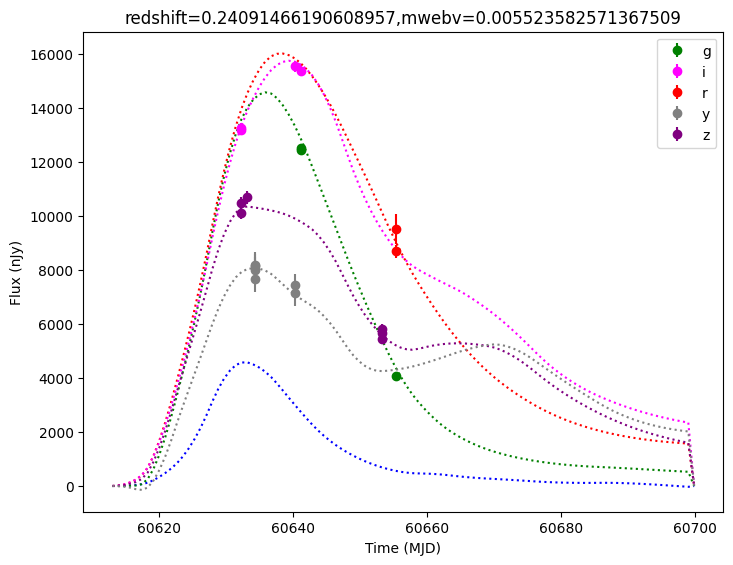

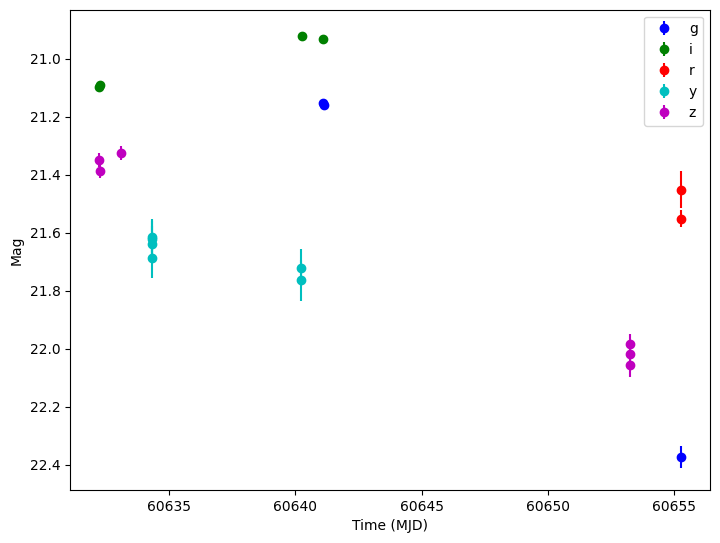

In [34]:
random_ids = lightcurves_after_dt.id.sample(1).values
colormap = {'u':'blue',
            'g':'green',
            'r':'red',
            'i':'magenta',
            'z':'purple',
            'y':'gray',
           }

for random_id in random_ids:
    # Extract the row for this object.
    # lc = lightcurves.loc[lightcurves.id==random_id]
    lc = lightcurves_after_detection.loc[lightcurves_after_detection.id==random_id]
    # print(lc["lightcurve.mjd"])
    
    if lc["nobs"].values[0] > 0:
        # Unpack the nested columns (filters, mjd, flux, and flux error).
        lc_filters = np.asarray(lc["lightcurve.filter"], dtype=str)
        lc_mjd = np.asarray(lc["lightcurve.mjd"], dtype=float)
        lc_flux = np.asarray(lc["lightcurve.flux"], dtype=float)
        lc_fluxerr = np.asarray(lc["lightcurve.fluxerr"], dtype=float)

        lc_mag = -2.5*np.log10(lc_flux) + 31.4
        lc_magerr = np.absolute(1.086*lc_fluxerr/lc_flux)
        
        plot_lightcurves(
            fluxes=lc_flux,
            times=lc_mjd,
            fluxerrs=lc_fluxerr,
            filters=lc_filters,
            colormap=colormap,
        )
        plt.ylabel('Flux (nJy)')
        plt.title(f"redshift={lc['z'].values[0]},mwebv={lc['params'].values[0]['mwext.ebv']}")

        model = sncosmo.Model(source=sncosmo_modelname,
                      effects=[sncosmo.F99Dust()],
                      effect_names=['mw'],
                      effect_frames=['obs'])
        pardict = {}
        for p in ['x0','x1','c','t0']:
            pardict[p] = lc['params'].values[0][f'source.{p}']
        pardict['mwebv'] = lc['params'].values[0]['mwext.ebv']
        pardict['z'] = lc['z'].values[0]
        model.update(pardict)
        t = np.linspace(-20,50,100)
        obstime = t*(1+pardict['z'])+pardict['t0']
        for b in 'ugrizy':
            try:
                plt.plot(obstime,model.bandflux('lsst'+b,obstime,zp=31.4,zpsys='ab'),ls=':',color=colormap[b])
            except:
                continue
        plt.legend()
        plt.show()

        plot_lightcurves(
            fluxes=lc_mag,
            times=lc_mjd,
            fluxerrs=lc_magerr,
            filters=lc_filters,
        )
        plt.ylabel('Mag')
        plt.ylim(plt.ylim()[::-1])
        plt.show()